In [2]:
import pint.models as model
import pint.logging
import numpy as np
import astropy.units as u
import astropy.constants as c
import pint.derived_quantities as dq
import table_utils as tu
import matplotlib.pyplot as plt

import matplotlib as mpl
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
params = {'text.usetex'       : True,
          'axes.unicode_minus': True}
mpl.rcParams.update(params)

pint.logging.setup(level="ERROR")

1

In [3]:
# reddening in PS1 bands from Schlafly & Finkbeiner 2011, Table 6
# grizy
ps1_redden=np.array([3.172,2.271,1.682,1.322,1.087]) # y not constraining?

# assume no detection.  Typical PS1 grizy stack limits are:
ps1_lims = np.array([23.3,23.2,23.1,22.3,21.4])

# extinction from http://argonaut.skymaps.info (see Green et al. 2015)
# these take distance (largest NE vs. YMW) into account
psr = "J0032+6946"
extinction = 0.91

par_path = f"data/{psr}_fiore+23.par"
mo = model.get_model(par_path)

mp = 1.4*u.Msun

pb = (1./mo['FB0'].quantity).to(u.day)

mcmax = dq.companion_mass(pb, mo['A1'].quantity, i=26.0*u.deg, mp=mp)
mcmed = dq.companion_mass(pb, mo['A1'].quantity, i=60.0*u.deg, mp=mp)
mcmin = dq.companion_mass(pb, mo['A1'].quantity, i=90.0*u.deg, mp=mp)

gcoord = mo.coords_as_GAL()
dmdist_ne, dmdist_ymw = tu.get_dmdists(gcoord,mo['DM'].value)

dmdist = max([dmdist_ne,dmdist_ymw])

distance_mod = 5*np.log10((dmdist*u.kpc/(10.0*u.pc)).decompose())

print(f"{psr}: {mcmin.value:.3f}-{mcmed.value:.3f}-{mcmax.value:.3f} Msun")
grizy_lims = ps1_lims-extinction*ps1_redden-distance_mod # de-reddened limits
print(grizy_lims)

J0032+6946: 0.417-0.496-1.212 Msun
[8.15744868 8.87735868 9.31334868 8.84094868 8.15479868]


In [4]:
import matplotlib.pyplot as plt
from astropy.units import cds

# > 0.3 Msun, WD behaves nicely (cold degenerate matter), has mass-radius relationship
# type of atmosphere can change, H (DA) vs. He (DB)
# abs. magnitude depends on surface temperature, which depends on age & mass (cooling models)
# with PanSTARRS nondetection, limit M -> limit Teff -> limit age for a given mass

m = 0.4956
psr = "J0032+6946"

#m, psr= ms[0], psrs[0]

# read in Bergeron tables (https://www.astro.umontreal.ca/~bergeron/CoolingModels/)

def COlimit(maglims,atmo="DA",m="0.4"):
    check_rows = np.loadtxt(f'data/berg{m}.txt',dtype=str,usecols=2)
    dbrow = np.max(np.where(check_rows=="Mo"))
    if atmo=="DA":
        teffs, g, r, i, z, y, ages = np.loadtxt(f'data/berg{m}.txt',dtype=str,skiprows=2,max_rows=dbrow-2, 
                                                usecols=[0,29,30,31,32,33,42],unpack=True)
        parenthesis = "(DA / H atmosphere)"
    elif atmo=="DB":
        teffs, g, r, i, z, y, ages = np.loadtxt(f'data/berg{m}.txt',dtype=str,skiprows=dbrow+3, 
                                                usecols=[0,29,30,31,32,33,42],unpack=True)
        parenthesis = "(DB / He atmosphere)"
    else:
        print("Atmosphere must be 'DA' or 'DB'")
        return
    grizydata = [g,r,i,z,y]
    bands = ['g','r','i','z','y']
    teff_lims = []
    age_lims = []
    for band, maglim, bergmags in zip(bands, maglims, grizydata):
        idx = (np.abs(maglim - np.array(bergmags).astype(float))).argmin()
        teff, age = teffs[idx], ages[idx]
        teff_lims.append(float(teff))
        age_lims.append(float(age))
        #print(f"{psr}: using values for {m} Msun, {band} band, cooling age {age} yr: {teff} K")
    idx = np.argmin(np.array(teff_lims))
    print(f"{psr}: Mc = {m} Msun, {bands[idx]}-band limited (M_{bands[idx]} < {maglims[idx]:.1f}), cooling age {age_lims[idx]*10**-6:.2f} Myr: {teff_lims[idx]:.0f} K {parenthesis}")

In [5]:
for mass in [0.4,0.5,0.6]:
    COlimit(maglims=grizy_lims,atmo="DA",m=str(mass))
    COlimit(maglims=grizy_lims,atmo="DB",m=str(mass))

J0032+6946: Mc = 0.4 Msun, r-band limited (M_r < 8.9), cooling age 0.94 Myr: 35000 K (DA / H atmosphere)
J0032+6946: Mc = 0.4 Msun, i-band limited (M_i < 9.3), cooling age 0.44 Myr: 40000 K (DB / He atmosphere)
J0032+6946: Mc = 0.5 Msun, r-band limited (M_r < 8.9), cooling age 1.74 Myr: 45000 K (DA / H atmosphere)
J0032+6946: Mc = 0.5 Msun, r-band limited (M_r < 8.9), cooling age 1.70 Myr: 47500 K (DB / He atmosphere)
J0032+6946: Mc = 0.6 Msun, r-band limited (M_r < 8.9), cooling age 1.51 Myr: 55000 K (DA / H atmosphere)
J0032+6946: Mc = 0.6 Msun, i-band limited (M_i < 9.3), cooling age 1.40 Myr: 60000 K (DB / He atmosphere)


In [6]:
# reddening in PS1 bands from Schlafly & Finkbeiner 2011, Table 6
# grizy
ps1_redden=np.array([3.172,2.271,1.682,1.322,1.087]) # y not constraining?

# assume no detection.  Typical PS1 grizy stack limits are:
ps1_lims = np.array([23.3,23.2,23.1,22.3,21.4])

# extinction from http://argonaut.skymaps.info (see Green et al. 2015)
# these take distance (largest NE vs. YMW) into account
psr = "J1239+3239"
extinction = 0.02

par_path = f"data/{psr}_fiore+23.par"
mo = model.get_model(par_path)

mp = 1.4*u.Msun

pb = (1./mo['FB0'].quantity).to(u.day)

mcmax = dq.companion_mass(pb, mo['A1'].quantity, i=26.0*u.deg, mp=mp)
mcmed = dq.companion_mass(pb, mo['A1'].quantity, i=60.0*u.deg, mp=mp)
mcmin = dq.companion_mass(pb, mo['A1'].quantity, i=90.0*u.deg, mp=mp)

gcoord = mo.coords_as_GAL()
dmdist_ne, dmdist_ymw = tu.get_dmdists(gcoord,mo['DM'].value)

dmdist = max([dmdist_ne,dmdist_ymw])
print(f"{dmdist} kpc")

distance_mod = 5*np.log10((dmdist*u.kpc/(10.0*u.pc)).decompose())

print(f"{psr}: {mcmin.value:.3f}-{mcmed.value:.3f}-{mcmax.value:.3f} Msun")
grizy_lims = ps1_lims-extinction*ps1_redden-distance_mod # de-reddened limits
print(grizy_lims)

2.232192138671875 kpc
J1239+3239: 0.126-0.147-0.310 Msun
[11.49290213 11.41092213 11.32270213 10.52990213  9.63460213]


In [7]:
# Kilic et al. (2021) WD sample
kilic_teff, kilic_teff_err, kilic_logg, kilic_logg_err, kilic_M, kilic_M_err = np.loadtxt("data/kilic+21_wdparams.dat",dtype=str,skiprows=5,usecols=[3,4,5,6,7,8],delimiter='|',unpack=True)
for i,te in enumerate(kilic_teff_err):
    try:
        test = float(te)
    except ValueError:
        kilic_teff_err[i] = "0"

kilic_R = np.sqrt(c.G * kilic_M.astype(float)*u.Msun / ((u.cm/u.s/u.s) * 10 ** kilic_logg.astype(float)))
kilic_R_err = (kilic_R/2) * np.sqrt((kilic_M_err.astype(float)/kilic_M.astype(float))**2 + (np.log(10)*kilic_logg_err.astype(float))**2)

# Kilic et al. (2022) ELM WDs

elm_teff, elm_teff_err, elm_logg, elm_logg_err, elm_M, elm_M_err = np.loadtxt("data/kilic+22_elm.dat",dtype=str,skiprows=46,usecols=[15,16,17,18,19,20],unpack=True)
for i,te in enumerate(elm_teff_err):
    try:
        test = float(te)
    except ValueError:
        elm_teff_err[i] = "0"

elm_R = np.sqrt(c.G * elm_M.astype(float)*u.Msun / ((u.cm/u.s/u.s) * 10 ** elm_logg.astype(float)))
elm_R_err = (elm_R/2) * np.sqrt((elm_M_err.astype(float)/elm_M.astype(float))**2 + (np.log(10)*elm_logg_err.astype(float))**2)

# # some ELM WDs from Althaus et al. (2013) (redundant with Kilic+22, older)
# althaus_teff, althaus_teff_err, althaus_logg, althaus_logg_err, althaus_M, althaus_M_err = np.loadtxt("data/althaus+13_knownwds.dat",dtype=str,usecols=[1,2,3,4,5,6],unpack=True)

# althaus_R = np.sqrt(c.G * althaus_M.astype(float)*u.Msun / ((u.cm/u.s/u.s) * 10 ** althaus_logg.astype(float)))
# althaus_R_err = (althaus_R/2) * np.sqrt((althaus_M_err.astype(float)/althaus_M.astype(float))**2 + (np.log(10)*althaus_logg_err.astype(float))**2)

In [8]:
def Helimit(maglims,radii,masses,atmo,tscale,max_DB_radius,save=False):
    if type(atmo) is not list:
        atmo = [atmo]
    lstyles = ['-','--'][:len(atmo)]
    maxRs = np.array([max(radii).value,max_DB_radius])*u.Rsun
    for atm,ls,maxR in zip(atmo,lstyles,maxRs):
        if type(masses) is not list:
            masses = [masses]
        for m in masses:
            check_rows = np.loadtxt(f'data/berg{m:.1f}.txt',dtype=str,usecols=2)
            dbrow = np.max(np.where(check_rows=="Mo"))
            if atm=="DA":
                teffs, logg, g, r, i, z, y, ages = np.loadtxt(f'data/berg{m:.1f}.txt',dtype=str,skiprows=2,max_rows=dbrow-2, 
                                                        usecols=[0,1,29,30,31,32,33,42],unpack=True)
                parenthesis = "(DA / H atmosphere)"
            elif atm=="DB":
                teffs, logg, g, r, i, z, y, ages = np.loadtxt(f'data/berg{m:.1f}.txt',dtype=str,skiprows=dbrow+3, 
                                                        usecols=[0,1,29,30,31,32,33,42],unpack=True)
                parenthesis = "(DB / He atmosphere)"
            else:
                print(f"What is {atmo}? Atmosphere must be 'DA' or 'DB'")
                return
            grizydata = [g,r,i,z,y]
            bands = ['g','r','i','z','y']
            
            Rs = np.array([])*u.Rsun
            for lg in logg:
                R = np.sqrt(c.G*m*u.Msun / ((10**float(lg))*u.cm*u.s**-2))
                Rs = np.append(Rs, R.to(u.Rsun))
            
            lessmaxR = radii <= maxR
            radii_trimmed = radii[lessmaxR]
            
            teff_lims = False
            for maglim, bergmags in zip(maglims[:3], grizydata):
                teff_new = np.array([])
                for new_r in radii_trimmed:
                    new_mags = np.array(bergmags.astype(float)) - 2.5*np.log10(((new_r/Rs).to(u.Rsun/u.Rsun))**2)
                    idx = (np.abs(maglim - new_mags.astype(float))).argmin()
                    teff = teffs[idx]
                    teff_new = np.append(teff_new,float(teff))
                try:
                    teff_lims = np.vstack((teff_lims,teff_new))
                except ValueError:
                    teff_lims = teff_new
            min_teff_lims = np.amin(teff_lims, axis=0)
            #print(radii_trimmed, min_teff_lims)
            plt.plot(radii_trimmed,min_teff_lims/tscale,c='black',ls=ls,lw=1,label=f"{atm} atmosphere")
    
    elm_col = 'b'
    #elm_label = ''
    elm_label = r'Brown et al.~(2022)'
    plt.errorbar(elm_R.to(u.Rsun),elm_teff.astype(float)/tscale,xerr=elm_R_err,yerr=elm_teff_err.astype(float)/tscale, \
                 fmt='o',mfc=elm_col,mec=elm_col,ecolor=elm_col,ms=1.5,capsize=1.,elinewidth=0.5, \
                 label=elm_label,alpha=0.6,zorder=1)
    
    kilic_col = 'gray'
    #kilic_label = ''
    kilic_label = r'Kilic et al.~(2020)'
    plt.errorbar(kilic_R.to(u.Rsun),kilic_teff.astype(float)/tscale,xerr=kilic_R_err,yerr=kilic_teff_err.astype(float)/tscale, \
                 fmt='o',mfc=kilic_col,mec=kilic_col,ecolor=kilic_col,ms=1.5,capsize=1.,elinewidth=0.5, \
                 label=kilic_label,alpha=0.6,zorder=1)
    
    #plt.loglog()
    plt.xscale('log')
    plt.xlabel(r"WD Radius (R$_\odot$)",fontsize=20)
    plt.ylabel(r"$T_\mathrm{eff}$ ($10^3$\,K)",fontsize=20)
    plt.xlim(min_radius, max_radius)
    plt.ylim(0.0,31000.0/tscale)
    plt.tick_params(axis='both', labelsize=16)
    #plt.legend(fontsize=13,ncol=2,columnspacing=0.8,framealpha=0.4,labelspacing=0.4)
    plt.legend(fontsize=14)
    #plt.grid(True)
    if save:
        plt.savefig("J1239_opticalconstraints.pdf",format="pdf",bbox_inches='tight',pad_inches=0.25)

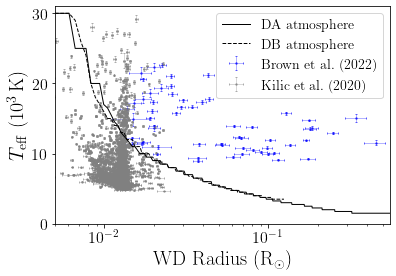

In [9]:
min_radius = 0.005
max_radius = 0.55
radii = np.linspace(min_radius,max_radius,1000)*u.Rsun
Helimit(grizy_lims,radii,masses=0.2,atmo=["DA","DB"],tscale=1000,max_DB_radius=0.125,save=False)